 # ADDA for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
from math import ceil
import glob
import os
import datetime

from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error

import torch
from torch.nn import functional as F
from torch import nn

from src.model.adda import ADDAST
from src.model.datasets import SpotDataset
from src.utils.data_processing import random_mix

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_26217/3165076490.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_MARKERS = 20
N_MIX = 8
N_SPOTS = 20000
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 1024
NUM_WORKERS = 8
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

SPATIALLIBD_DIR = "./data/spatialLIBD"
SC_DLPFC_PATH = "./data/sc_dlpfc/adata_sc_dlpfc.h5ad"


In [3]:
results_folder = os.path.join("results", script_start_time)
model_folder = os.path.join("model", script_start_time)

model_folder = os.path.join("model", "TESTING")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)


 # Prepare Data
 ## Data load
 ### Load SpatialLIBD Data

In [4]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(SPATIALLIBD_DIR, "adata")

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, "adata_spatialLIBD-*.h5ad")):
    sample_id = name.partition("-")[2].rpartition(".")[0]
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.6.0
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
leidenalg                   0.8.10
llvmlite                    0.38.0
matplotlib                  3.5.1
matplo

 ### Load Single Cell Data

In [5]:
adata_sc_dlpfc = sc.read_h5ad(SC_DLPFC_PATH)
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e4)
adata_sc_dlpfc.var_names_make_unique()


normalizing counts per cell
    finished (0:00:00)


 ## Find Marker Genes

In [6]:
# Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])


In [7]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')


In [8]:
df_genelists = pd.read_pickle("data/sc_dlpfc/df_genelists.pkl")
res_genes = []
for column in df_genelists.head(NUM_MARKERS):
    res_genes.extend(df_genelists.head(NUM_MARKERS)[column].tolist())
res_genes_ = list(set(res_genes))


 ### Select same gene features

In [9]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), label="sample_id", keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e4)
st_sample_id_l = adata_spatialLIBD.obs["sample_id"].unique()


normalizing counts per cell


/home/wma/miniconda3/envs/agreda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [10]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print("Selected Feature Gene number", len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


Selected Feature Gene number 362


 ## Format Data

### Array of single cell & spatial data
- Single cell data with labels
- Spatial data without labels

 ### Generate Pseudospots

In [11]:
def log_minmaxscale(arr):
    """returns log1pc and min/max normalized arr"""
    arrd = len(arr)
    arr = np.log1p(arr)

    arr_minus_min = arr - np.reshape(np.min(arr, axis=1), (arrd, 1))
    min2max = np.reshape((np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1))
    return arr_minus_min / min2max


In [12]:
df_sc = adata_sc_dlpfc.to_df()
df_sc.index = pd.MultiIndex.from_frame(adata_sc_dlpfc.obs.reset_index())

sc_sub_dict = dict(zip(range(df_genelists.shape[1]), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())


In [13]:
lab_sc_sub = df_sc.index.get_level_values("cell_subclass")
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype="int")

mat_sc_train, mat_sc_eval, lab_sc_num_train, lab_sc_num_eval = train_test_split(
    df_sc.to_numpy(),
    lab_sc_num,
    test_size=0.2,
    random_state=225,
    stratify=lab_sc_num,
)

mat_sc_val, mat_sc_test, lab_sc_num_val, lab_sc_num_test = train_test_split(
    mat_sc_eval,
    lab_sc_num_eval,
    test_size=0.5,
    random_state=263,
    stratify=lab_sc_num_eval,
)

sc_mix_train, lab_mix_train = random_mix(
    mat_sc_train, lab_sc_num_train, nmix=N_MIX, n_samples=N_SPOTS
)
sc_mix_val, lab_mix_val = random_mix(
    mat_sc_val, lab_sc_num_val, nmix=N_MIX, n_samples=N_SPOTS // 8
)
sc_mix_test, lab_mix_test = random_mix(
    mat_sc_test, lab_sc_num_test, nmix=N_MIX, n_samples=N_SPOTS // 8
)


sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_val_s = log_minmaxscale(sc_mix_val)
sc_mix_test_s = log_minmaxscale(sc_mix_test)


 ### Format Spatial Data

In [14]:
mat_sp_test_d = {}
mat_sp_test_s_d = {}
for sample_id in st_sample_id_l:
    mat_sp_test_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ].X.todense()

    mat_sp_test_s_d[sample_id] = log_minmaxscale(mat_sp_test_d[sample_id])

if TRAIN_USING_ALL_ST_SAMPLES:
    mat_sp_train = adata_spatialLIBD.X.todense()
    mat_sp_train_s = log_minmaxscale(mat_sp_train)
else:
    mat_sp_train_d = mat_sp_test_d
    mat_sp_train_s_d = mat_sp_test_s_d


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [17]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

### target dataloaders
target_test_set_d = {}
for sample_id in st_sample_id_l:
    target_test_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])

dataloader_target_test_d = {}
for sample_id in st_sample_id_l:
    dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
        target_test_set_d[sample_id],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(mat_sp_train_s)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
else:
    target_train_set_d = {}
    dataloader_target_train_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
        )


In [19]:
# mat_sc


 ## Define Model

In [20]:
model = ADDAST(sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1])
model.to(device)


ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Predictor(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Log

 ## Pretrain

In [21]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [22]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer,
    max_lr=0.002,
    steps_per_epoch=len(dataloader_source_train),
    epochs=INITIAL_TRAIN_EPOCHS,
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [23]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [24]:
model.pretraining()


In [25]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

# Train
print("Start pretrain...")
outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)
for epoch in range(INITIAL_TRAIN_EPOCHS):

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT and epoch > MIN_EPOCHS:
        print(
            f"Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch"
        )
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
            "scheduler": pre_scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"earlystop_{epoch}.pth"))
        break

    early_stop_count += 1

    # Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  # force print final state
    inner.reset()  # reuse bar
    for _, batch in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())

        pre_optimizer.zero_grad()
        loss = model_loss(*batch, model)
        loss_running.append(loss.item())
        mean_weights.append(len(batch))  # we will weight average by batch size later

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        pre_scheduler.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))
    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_val, model)
        loss_history_val.append(curr_loss_val)

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
            "scheduler": pre_scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
            "scheduler": pre_scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "train loss:",
        round(loss_history[-1], 6),
        "validation loss:",
        round(loss_history_val[-1], 6),
        # "next_lr:", scheduler.get_last_lr(),
    )

# Save final model
checkpoint = {
    "epoch": epoch,
    "model": model,
    "optimizer": pre_optimizer,
    "scheduler": pre_scheduler,
    # 'scaler': scaler
}
torch.save(checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 train loss: 1.766591 validation loss: 1.587768
epoch: 1 train loss: 1.485969 validation loss: 1.419202
epoch: 2 train loss: 1.374599 validation loss: 1.318157
epoch: 3 train loss: 1.303996 validation loss: 1.295271
epoch: 4 train loss: 1.244986 validation loss: 1.227159
epoch: 5 train loss: 1.187055 validation loss: 1.177847
epoch: 6 train loss: 1.127582 validation loss: 1.116533
epoch: 7 train loss: 1.063826 validation loss: 1.060705
epoch: 8 train loss: 0.996568 validation loss: 0.995302
epoch: 9 train loss: 0.924811 validation loss: 0.931286
epoch: 10 train loss: 0.849864 validation loss: 0.852934
epoch: 11 train loss: 0.775506 validation loss: 0.814536
epoch: 12 train loss: 0.706865 validation loss: 0.762884
epoch: 13 train loss: 0.645851 validation loss: 0.692631
epoch: 14 train loss: 0.598052 validation loss: 0.703456
epoch: 15 train loss: 0.566518 validation loss: 0.667794
epoch: 16 train loss: 0.544128 validation loss: 0.670056
epoch: 17 train loss: 0.525571 validation

 ## Adversarial Adaptation

In [26]:
EPOCHS = 50
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS


In [27]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [28]:
def cycle_iter(iter):
    while True:
        yield from iter


In [29]:
criterion_dis = nn.CrossEntropyLoss()


In [30]:
def train_adversarial(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
):

    model.to(device)
    model.advtraining()

    target_optimizer = torch.optim.Adam(
        model.target_encoder.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-07
    )

    dis_optimizer = torch.optim.Adam(
        model.dis.parameters(), lr=0.00025, betas=(0.9, 0.999), eps=1e-07
    )

    iters = max(len(dataloader_source_train), len(dataloader_target_train))

    dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    )
    target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    )

    n_samples_source = len(dataloader_source_train.dataset)
    n_samples_target = len(dataloader_target_train.dataset)
    p = n_samples_source / (n_samples_source + n_samples_target)
    rand_loss = -(p * np.log(0.5)) - (1 - p) * np.log(0.5)

    # Initialize lists to store loss and accuracy values
    loss_history = []
    accu_history = []
    loss_history_running = []

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0

    # Train
    print("Start adversarial training...")
    print("Discriminator target loss:", rand_loss)
    outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
    inner1 = tqdm(total=iters, desc=f"Batch (Discriminator)", position=1)
    inner2 = tqdm(total=iters, desc=f"Batch (Encoder)", position=2)
    for epoch in range(EPOCHS):

        # check to see if validation loss has plateau'd
        if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV:
            print(
                f"Discriminator loss plateaud; failed to get worse after {early_stop_count} at {epoch}th epoch"
            )
            checkpoint = {
                "epoch": EPOCHS,
                "model": model,
                "dis_optimizer": dis_optimizer,
                "target_optimizer": target_optimizer,
                # 'dis_scheduler': dis_scheduler,
                # 'target_scheduler': target_scheduler,
                # 'scaler': scaler
            }
            torch.save(checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth"))
            break

        early_stop_count += 1

        # Train mode
        model.train()

        loss_running = []
        accu_running = []
        mean_weights = []

        model.train_discriminator()
        model.target_encoder.eval()
        model.source_encoder.eval()
        model.dis.train()

        inner1.refresh()  # force print final state
        inner1.reset()  # reuse bar
        inner2.refresh()  # force print final state
        inner2.reset()  # reuse bar

        batch_cycler = zip(
            cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
        )
        for _ in range(iters):
            # lr_history_running.append(scheduler.get_last_lr())

            (x_source, _), (x_target, _) = next(batch_cycler)
            x_source, x_target = x_source.to(device), x_target.to(device)

            dis_optimizer.zero_grad()
            y_dis = torch.cat(
                [
                    torch.ones(x_source.shape[0], device=device, dtype=torch.long),
                    torch.zeros(x_target.shape[0], device=device, dtype=torch.long),
                ]
            )

            emb_source = model.source_encoder(x_source).view(x_source.shape[0], -1)
            emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)

            emb_all = torch.cat((emb_source, emb_target))

            y_pred = model.dis(emb_all)

            # we will weight average by batch size later
            mean_weights.append(len(y_dis))

            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss = criterion_dis(y_pred, y_dis)
            loss_running.append(loss.item())
            accu_running.append(
                torch.mean(
                    (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(
                        torch.float32
                    )
                ).cpu()
            )

            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss.backward()
            dis_optimizer.step()
            dis_scheduler.step()

            inner1.update(1)

        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))

        loss_history_running.append(loss_running)

        model.train_target_encoder()
        model.target_encoder.train()
        model.source_encoder.eval()
        model.dis.eval()

        batch_cycler = zip(
            cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
        )
        for _ in range(iters):
            _, (x_target, _) = next(batch_cycler)
            x_target = x_target.to(device)

            target_optimizer.zero_grad()

            # flip label
            y_dis = torch.ones(x_target.shape[0], device=device, dtype=torch.long)

            emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)
            y_pred = model.dis(emb_target)
            loss = criterion_dis(y_pred, y_dis)

            loss.backward()
            target_optimizer.step()
            target_scheduler.step()

            inner2.update(1)

        # Save the best weights
        if math.fabs(loss_history[-1] - rand_loss) < best_loss_val:
            best_loss_val = math.fabs(loss_history[-1] - rand_loss)
            checkpoint = {
                "epoch": iters,
                "model": model,
                "dis_optimizer": dis_optimizer,
                "target_optimizer": target_optimizer,
                # 'dis_scheduler': dis_scheduler,
                # 'target_scheduler': target_scheduler,
            }
            torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))

            early_stop_count = 0

        # Save checkpoint every 10
        if epoch % 10 == 0 or epoch >= EPOCHS - 1:
            checkpoint = {
                "epoch": iters,
                "model": model,
                "dis_optimizer": dis_optimizer,
                "target_optimizer": target_optimizer,
                # 'dis_scheduler': dis_scheduler,
                # 'target_scheduler': target_scheduler,
            }
            torch.save(checkpoint, os.path.join(save_folder, f"checkpt{iters}.pth"))

        # Print the results
        outer.update(1)
        print(
            "epoch:",
            epoch,
            "dis loss:",
            round(loss_history[-1], 6),
            "dis accu:",
            round(accu_history[-1], 6),
            "difference from random loss:",
            round(math.fabs(loss_history[-1] - rand_loss), 6)
            # "next_lr:", scheduler.get_last_lr(),
        )

    # Save final model
    checkpoint = {
        "epoch": iters,
        "model": model,
        "dis_optimizer": dis_optimizer,
        "target_optimizer": target_optimizer,
        # 'dis_scheduler': dis_scheduler,
        # 'target_scheduler': target_scheduler,
    }
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))


In [31]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)
    model.advtraining()

    train_adversarial(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
        model = best_checkpoint["model"]
        model.to(device)
        model.advtraining()

        train_adversarial(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
        )


Adversarial training for ST slide 151510: 
Start adversarial training...
Discriminator target loss: 0.6931471805599452


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.5996 dis accu: 0.784617 difference from random loss: 0.093547
epoch: 1 dis loss: 0.721229 dis accu: 0.552756 difference from random loss: 0.028082
epoch: 2 dis loss: 0.732109 dis accu: 0.545464 difference from random loss: 0.038962
epoch: 3 dis loss: 0.76164 dis accu: 0.514532 difference from random loss: 0.068492
epoch: 4 dis loss: 0.758059 dis accu: 0.51941 difference from random loss: 0.064912
epoch: 5 dis loss: 0.739395 dis accu: 0.535966 difference from random loss: 0.046248
epoch: 6 dis loss: 0.707177 dis accu: 0.570402 difference from random loss: 0.01403
epoch: 7 dis loss: 0.658738 dis accu: 0.632655 difference from random loss: 0.034409
epoch: 8 dis loss: 0.624882 dis accu: 0.679391 difference from random loss: 0.068265
epoch: 9 dis loss: 0.597188 dis accu: 0.711283 difference from random loss: 0.095959
epoch: 10 dis loss: 0.55517 dis accu: 0.752958 difference from random loss: 0.137977
epoch: 11 dis loss: 0.566097 dis accu: 0.746808 difference from random

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.60318 dis accu: 0.774075 difference from random loss: 0.089968
epoch: 1 dis loss: 0.718386 dis accu: 0.553217 difference from random loss: 0.025239
epoch: 2 dis loss: 0.746791 dis accu: 0.529142 difference from random loss: 0.053643
epoch: 3 dis loss: 0.769454 dis accu: 0.501019 difference from random loss: 0.076307
epoch: 4 dis loss: 0.760881 dis accu: 0.507265 difference from random loss: 0.067734
epoch: 5 dis loss: 0.744124 dis accu: 0.523512 difference from random loss: 0.050977
epoch: 6 dis loss: 0.719898 dis accu: 0.550777 difference from random loss: 0.026751
epoch: 7 dis loss: 0.670536 dis accu: 0.612091 difference from random loss: 0.022612
epoch: 8 dis loss: 0.627923 dis accu: 0.668633 difference from random loss: 0.065224
epoch: 9 dis loss: 0.606663 dis accu: 0.691662 difference from random loss: 0.086484
epoch: 10 dis loss: 0.574699 dis accu: 0.728928 difference from random loss: 0.118449
epoch: 11 dis loss: 0.574526 dis accu: 0.734745 difference from r

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.598371 dis accu: 0.783188 difference from random loss: 0.094776
epoch: 1 dis loss: 0.717999 dis accu: 0.556757 difference from random loss: 0.024852
epoch: 2 dis loss: 0.745294 dis accu: 0.530796 difference from random loss: 0.052147
epoch: 3 dis loss: 0.768719 dis accu: 0.500847 difference from random loss: 0.075572
epoch: 4 dis loss: 0.7617 dis accu: 0.505904 difference from random loss: 0.068553
epoch: 5 dis loss: 0.739238 dis accu: 0.528033 difference from random loss: 0.046091
epoch: 6 dis loss: 0.711125 dis accu: 0.56502 difference from random loss: 0.017978
epoch: 7 dis loss: 0.666947 dis accu: 0.626743 difference from random loss: 0.0262
epoch: 8 dis loss: 0.621922 dis accu: 0.679082 difference from random loss: 0.071225
epoch: 9 dis loss: 0.580457 dis accu: 0.725792 difference from random loss: 0.11269
epoch: 10 dis loss: 0.550267 dis accu: 0.760407 difference from random loss: 0.14288
epoch: 11 dis loss: 0.559441 dis accu: 0.752405 difference from random 

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.608064 dis accu: 0.773762 difference from random loss: 0.085083
epoch: 1 dis loss: 0.718739 dis accu: 0.556164 difference from random loss: 0.025592
epoch: 2 dis loss: 0.751293 dis accu: 0.521812 difference from random loss: 0.058146
epoch: 3 dis loss: 0.763496 dis accu: 0.505743 difference from random loss: 0.070349
epoch: 4 dis loss: 0.764261 dis accu: 0.505005 difference from random loss: 0.071114
epoch: 5 dis loss: 0.74534 dis accu: 0.520943 difference from random loss: 0.052192
epoch: 6 dis loss: 0.708431 dis accu: 0.566781 difference from random loss: 0.015284
epoch: 7 dis loss: 0.672911 dis accu: 0.615148 difference from random loss: 0.020236
epoch: 8 dis loss: 0.628539 dis accu: 0.668493 difference from random loss: 0.064608
epoch: 9 dis loss: 0.587676 dis accu: 0.71931 difference from random loss: 0.105471
epoch: 10 dis loss: 0.561356 dis accu: 0.745522 difference from random loss: 0.131791
epoch: 11 dis loss: 0.534868 dis accu: 0.775448 difference from ra

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.604544 dis accu: 0.774393 difference from random loss: 0.088604
epoch: 1 dis loss: 0.723994 dis accu: 0.5506 difference from random loss: 0.030847
epoch: 2 dis loss: 0.733612 dis accu: 0.53905 difference from random loss: 0.040464
epoch: 3 dis loss: 0.766596 dis accu: 0.504134 difference from random loss: 0.073449
epoch: 4 dis loss: 0.755914 dis accu: 0.522166 difference from random loss: 0.062767
epoch: 5 dis loss: 0.737654 dis accu: 0.534836 difference from random loss: 0.044507
epoch: 6 dis loss: 0.716002 dis accu: 0.556922 difference from random loss: 0.022854
epoch: 7 dis loss: 0.665119 dis accu: 0.623553 difference from random loss: 0.028029
epoch: 8 dis loss: 0.6285 dis accu: 0.669619 difference from random loss: 0.064648
epoch: 9 dis loss: 0.619925 dis accu: 0.685756 difference from random loss: 0.073222
epoch: 10 dis loss: 0.552542 dis accu: 0.754975 difference from random loss: 0.140605
epoch: 11 dis loss: 0.527351 dis accu: 0.779941 difference from rando

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.599177 dis accu: 0.782509 difference from random loss: 0.09397
epoch: 1 dis loss: 0.717387 dis accu: 0.556455 difference from random loss: 0.02424
epoch: 2 dis loss: 0.737811 dis accu: 0.538389 difference from random loss: 0.044664
epoch: 3 dis loss: 0.761521 dis accu: 0.513118 difference from random loss: 0.068374
epoch: 4 dis loss: 0.760905 dis accu: 0.515807 difference from random loss: 0.067758
epoch: 5 dis loss: 0.733931 dis accu: 0.544185 difference from random loss: 0.040784
epoch: 6 dis loss: 0.699198 dis accu: 0.585746 difference from random loss: 0.006051
epoch: 7 dis loss: 0.655864 dis accu: 0.639916 difference from random loss: 0.037283
epoch: 8 dis loss: 0.629623 dis accu: 0.67067 difference from random loss: 0.063525
epoch: 9 dis loss: 0.559791 dis accu: 0.748231 difference from random loss: 0.133356
epoch: 10 dis loss: 0.598199 dis accu: 0.716825 difference from random loss: 0.094949
epoch: 11 dis loss: 0.611204 dis accu: 0.703459 difference from ran

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.613809 dis accu: 0.761443 difference from random loss: 0.079338
epoch: 1 dis loss: 0.760556 dis accu: 0.519237 difference from random loss: 0.067409
epoch: 2 dis loss: 0.739575 dis accu: 0.531312 difference from random loss: 0.046427
epoch: 3 dis loss: 0.707136 dis accu: 0.561169 difference from random loss: 0.013988
epoch: 4 dis loss: 0.72742 dis accu: 0.537898 difference from random loss: 0.034272
epoch: 5 dis loss: 0.710319 dis accu: 0.556531 difference from random loss: 0.017172
epoch: 6 dis loss: 0.716298 dis accu: 0.547009 difference from random loss: 0.023151
epoch: 7 dis loss: 0.68956 dis accu: 0.584715 difference from random loss: 0.003587
epoch: 8 dis loss: 0.652275 dis accu: 0.626701 difference from random loss: 0.040872
epoch: 9 dis loss: 0.626837 dis accu: 0.663008 difference from random loss: 0.06631
epoch: 10 dis loss: 0.612727 dis accu: 0.67607 difference from random loss: 0.08042
epoch: 11 dis loss: 0.609895 dis accu: 0.683782 difference from rando

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.6074 dis accu: 0.772565 difference from random loss: 0.085747
epoch: 1 dis loss: 0.729569 dis accu: 0.543105 difference from random loss: 0.036422
epoch: 2 dis loss: 0.72896 dis accu: 0.544224 difference from random loss: 0.035813
epoch: 3 dis loss: 0.763632 dis accu: 0.507966 difference from random loss: 0.070485
epoch: 4 dis loss: 0.756461 dis accu: 0.515105 difference from random loss: 0.063314
epoch: 5 dis loss: 0.747303 dis accu: 0.524963 difference from random loss: 0.054156
epoch: 6 dis loss: 0.706414 dis accu: 0.568175 difference from random loss: 0.013267
epoch: 7 dis loss: 0.680884 dis accu: 0.600464 difference from random loss: 0.012263
epoch: 8 dis loss: 0.639153 dis accu: 0.653426 difference from random loss: 0.053994
epoch: 9 dis loss: 0.609954 dis accu: 0.688939 difference from random loss: 0.083193
epoch: 10 dis loss: 0.56623 dis accu: 0.740036 difference from random loss: 0.126917
epoch: 11 dis loss: 0.556193 dis accu: 0.747922 difference from rand

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.611557 dis accu: 0.766882 difference from random loss: 0.08159
epoch: 1 dis loss: 0.727192 dis accu: 0.547176 difference from random loss: 0.034045
epoch: 2 dis loss: 0.739831 dis accu: 0.532788 difference from random loss: 0.046684
epoch: 3 dis loss: 0.764277 dis accu: 0.506639 difference from random loss: 0.07113
epoch: 4 dis loss: 0.763334 dis accu: 0.508752 difference from random loss: 0.070187
epoch: 5 dis loss: 0.747798 dis accu: 0.521569 difference from random loss: 0.054651
epoch: 6 dis loss: 0.713525 dis accu: 0.554628 difference from random loss: 0.020378
epoch: 7 dis loss: 0.687726 dis accu: 0.590343 difference from random loss: 0.005421
epoch: 8 dis loss: 0.653123 dis accu: 0.636137 difference from random loss: 0.040024
epoch: 9 dis loss: 0.60154 dis accu: 0.692933 difference from random loss: 0.091607
epoch: 10 dis loss: 0.602881 dis accu: 0.692418 difference from random loss: 0.090267
epoch: 11 dis loss: 0.556914 dis accu: 0.743144 difference from ran

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.599795 dis accu: 0.784631 difference from random loss: 0.093352
epoch: 1 dis loss: 0.717775 dis accu: 0.554398 difference from random loss: 0.024628
epoch: 2 dis loss: 0.740259 dis accu: 0.532537 difference from random loss: 0.047112
epoch: 3 dis loss: 0.767377 dis accu: 0.506538 difference from random loss: 0.07423
epoch: 4 dis loss: 0.760128 dis accu: 0.517188 difference from random loss: 0.066981
epoch: 5 dis loss: 0.740661 dis accu: 0.539202 difference from random loss: 0.047514
epoch: 6 dis loss: 0.70606 dis accu: 0.577868 difference from random loss: 0.012913
epoch: 7 dis loss: 0.658731 dis accu: 0.635586 difference from random loss: 0.034416
epoch: 8 dis loss: 0.630005 dis accu: 0.670957 difference from random loss: 0.063142
epoch: 9 dis loss: 0.583501 dis accu: 0.724563 difference from random loss: 0.109646
epoch: 10 dis loss: 0.541714 dis accu: 0.769512 difference from random loss: 0.151433
epoch: 11 dis loss: 0.563189 dis accu: 0.751762 difference from ra

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.60279 dis accu: 0.779395 difference from random loss: 0.090357
epoch: 1 dis loss: 0.709772 dis accu: 0.562142 difference from random loss: 0.016625
epoch: 2 dis loss: 0.750074 dis accu: 0.522869 difference from random loss: 0.056926
epoch: 3 dis loss: 0.767948 dis accu: 0.500589 difference from random loss: 0.074801
epoch: 4 dis loss: 0.764553 dis accu: 0.502684 difference from random loss: 0.071406
epoch: 5 dis loss: 0.745845 dis accu: 0.520618 difference from random loss: 0.052698
epoch: 6 dis loss: 0.706647 dis accu: 0.565231 difference from random loss: 0.013499
epoch: 7 dis loss: 0.673151 dis accu: 0.618746 difference from random loss: 0.019996
epoch: 8 dis loss: 0.626732 dis accu: 0.671816 difference from random loss: 0.066416
epoch: 9 dis loss: 0.576154 dis accu: 0.732138 difference from random loss: 0.116993
epoch: 10 dis loss: 0.560764 dis accu: 0.748972 difference from random loss: 0.132383
epoch: 11 dis loss: 0.58401 dis accu: 0.729729 difference from ra

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.597673 dis accu: 0.792215 difference from random loss: 0.095475
epoch: 1 dis loss: 0.716354 dis accu: 0.557979 difference from random loss: 0.023207
epoch: 2 dis loss: 0.734134 dis accu: 0.536669 difference from random loss: 0.040986
epoch: 3 dis loss: 0.757258 dis accu: 0.511591 difference from random loss: 0.064111
epoch: 4 dis loss: 0.758749 dis accu: 0.516856 difference from random loss: 0.065602
epoch: 5 dis loss: 0.729666 dis accu: 0.552938 difference from random loss: 0.036519
epoch: 6 dis loss: 0.705263 dis accu: 0.585253 difference from random loss: 0.012116
epoch: 7 dis loss: 0.657304 dis accu: 0.645939 difference from random loss: 0.035843
epoch: 8 dis loss: 0.628113 dis accu: 0.681547 difference from random loss: 0.065034
epoch: 9 dis loss: 0.581766 dis accu: 0.734972 difference from random loss: 0.111382
epoch: 10 dis loss: 0.482683 dis accu: 0.819638 difference from random loss: 0.210464
epoch: 11 dis loss: 0.461421 dis accu: 0.833936 difference from 

 # 4. Predict cell fraction of spots and visualization

In [32]:
pred_sp_d, pred_sp_noda_d = {}, {}
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"best_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.target_inference()
    with torch.no_grad():
        for sample_id in st_sample_id_l:
            pred_sp_d[sample_id] = (
                F.softmax(
                    model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1
                )
                .detach()
                .cpu()
                .numpy()
            )


else:
    for sample_id in st_sample_id_l:
        best_checkpoint = torch.load(
            os.path.join(advtrain_folder, sample_id, f"best_model.pth")
        )
        model = best_checkpoint["model"]
        model.to(device)

        model.eval()
        model.target_inference()

        with torch.no_grad():
            pred_sp_d[sample_id] = (
                F.softmax(
                    model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1
                )
                .detach()
                .cpu()
                .numpy()
            )


best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

with torch.no_grad():
    for sample_id in st_sample_id_l:
        pred_sp_noda_d[sample_id] = (
            F.softmax(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1)
            .detach()
            .cpu()
            .numpy()
        )

for sample_id in st_sample_id_l:
    adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ]
    adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
        adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
    )


In [33]:
# best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
# model = best_checkpoint["model"]
# model.to(device)
# model.eval()
# model.set_encoder("source")

# pred_sp_noda = (
#     F.softmax(model(torch.Tensor(mat_sp_test_s).to(device)), dim=1)
#     .detach()
#     .cpu()
#     .numpy()
# )
# adata_spatialLIBD_151673 =  adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == 151673]

# adata_spatialLIBD_151673.obsm['spatial'] = adata_spatialLIBD_151673.obs[['X','Y']].values


In [34]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l


[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [35]:
Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}


In [36]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [37]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )


In [38]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


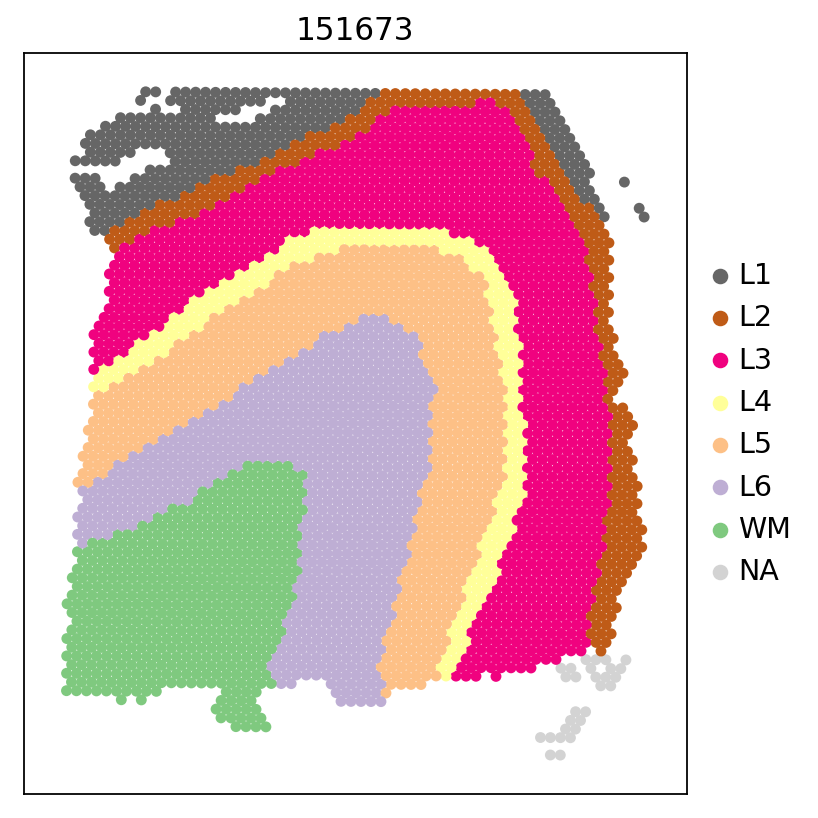

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_d[SAMPLE_ID_N],
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title=SAMPLE_ID_N,
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


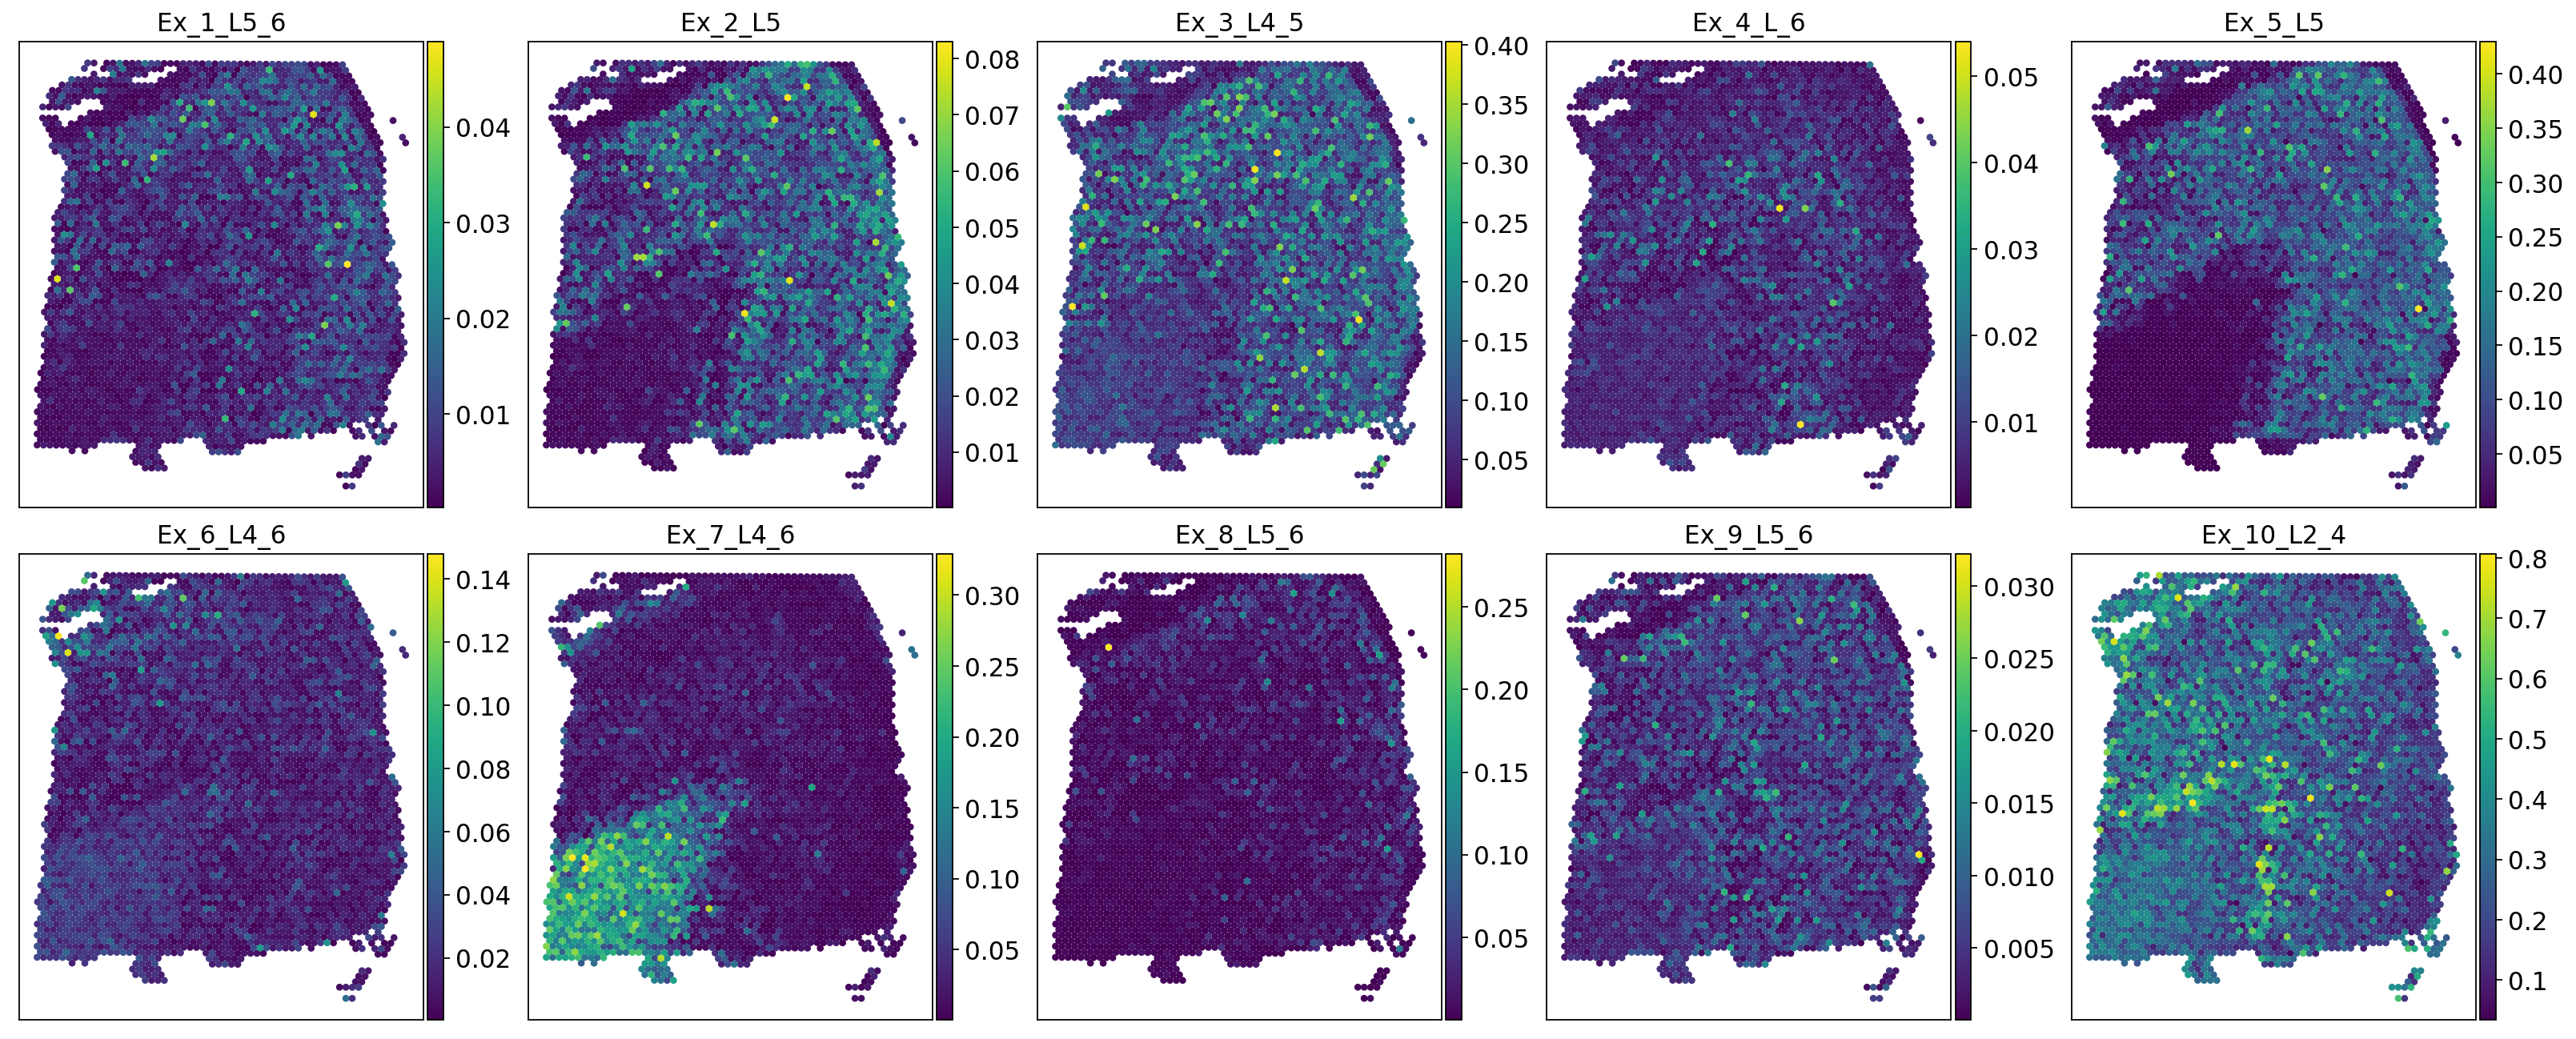

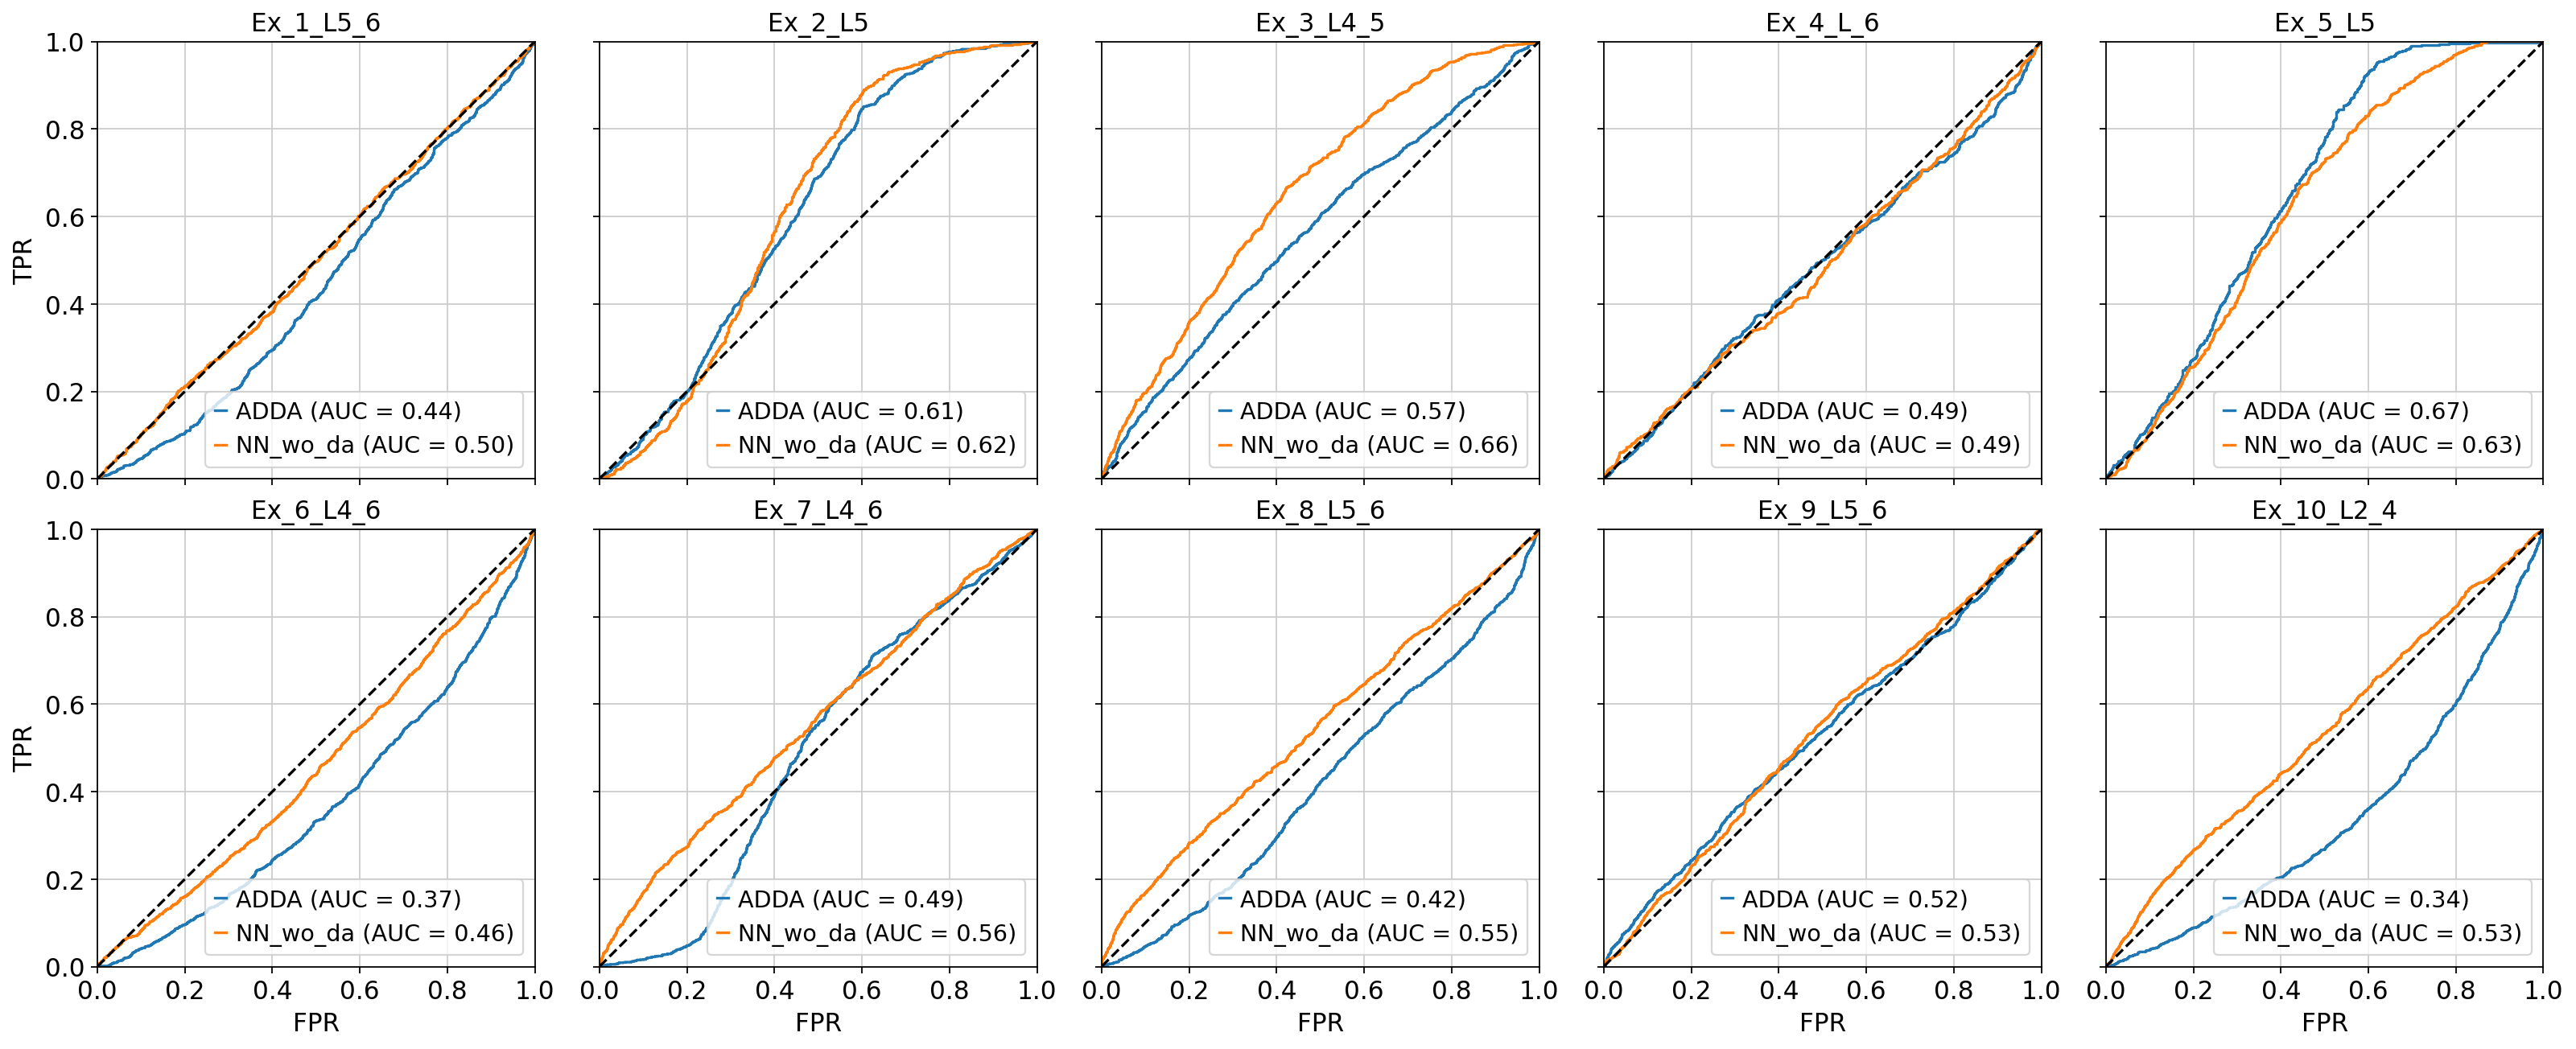

In [40]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(
        num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
    )
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_d[SAMPLE_ID_N],
        "ADDA",
        ax.flat[i],
    )
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_noda_d[SAMPLE_ID_N],
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()


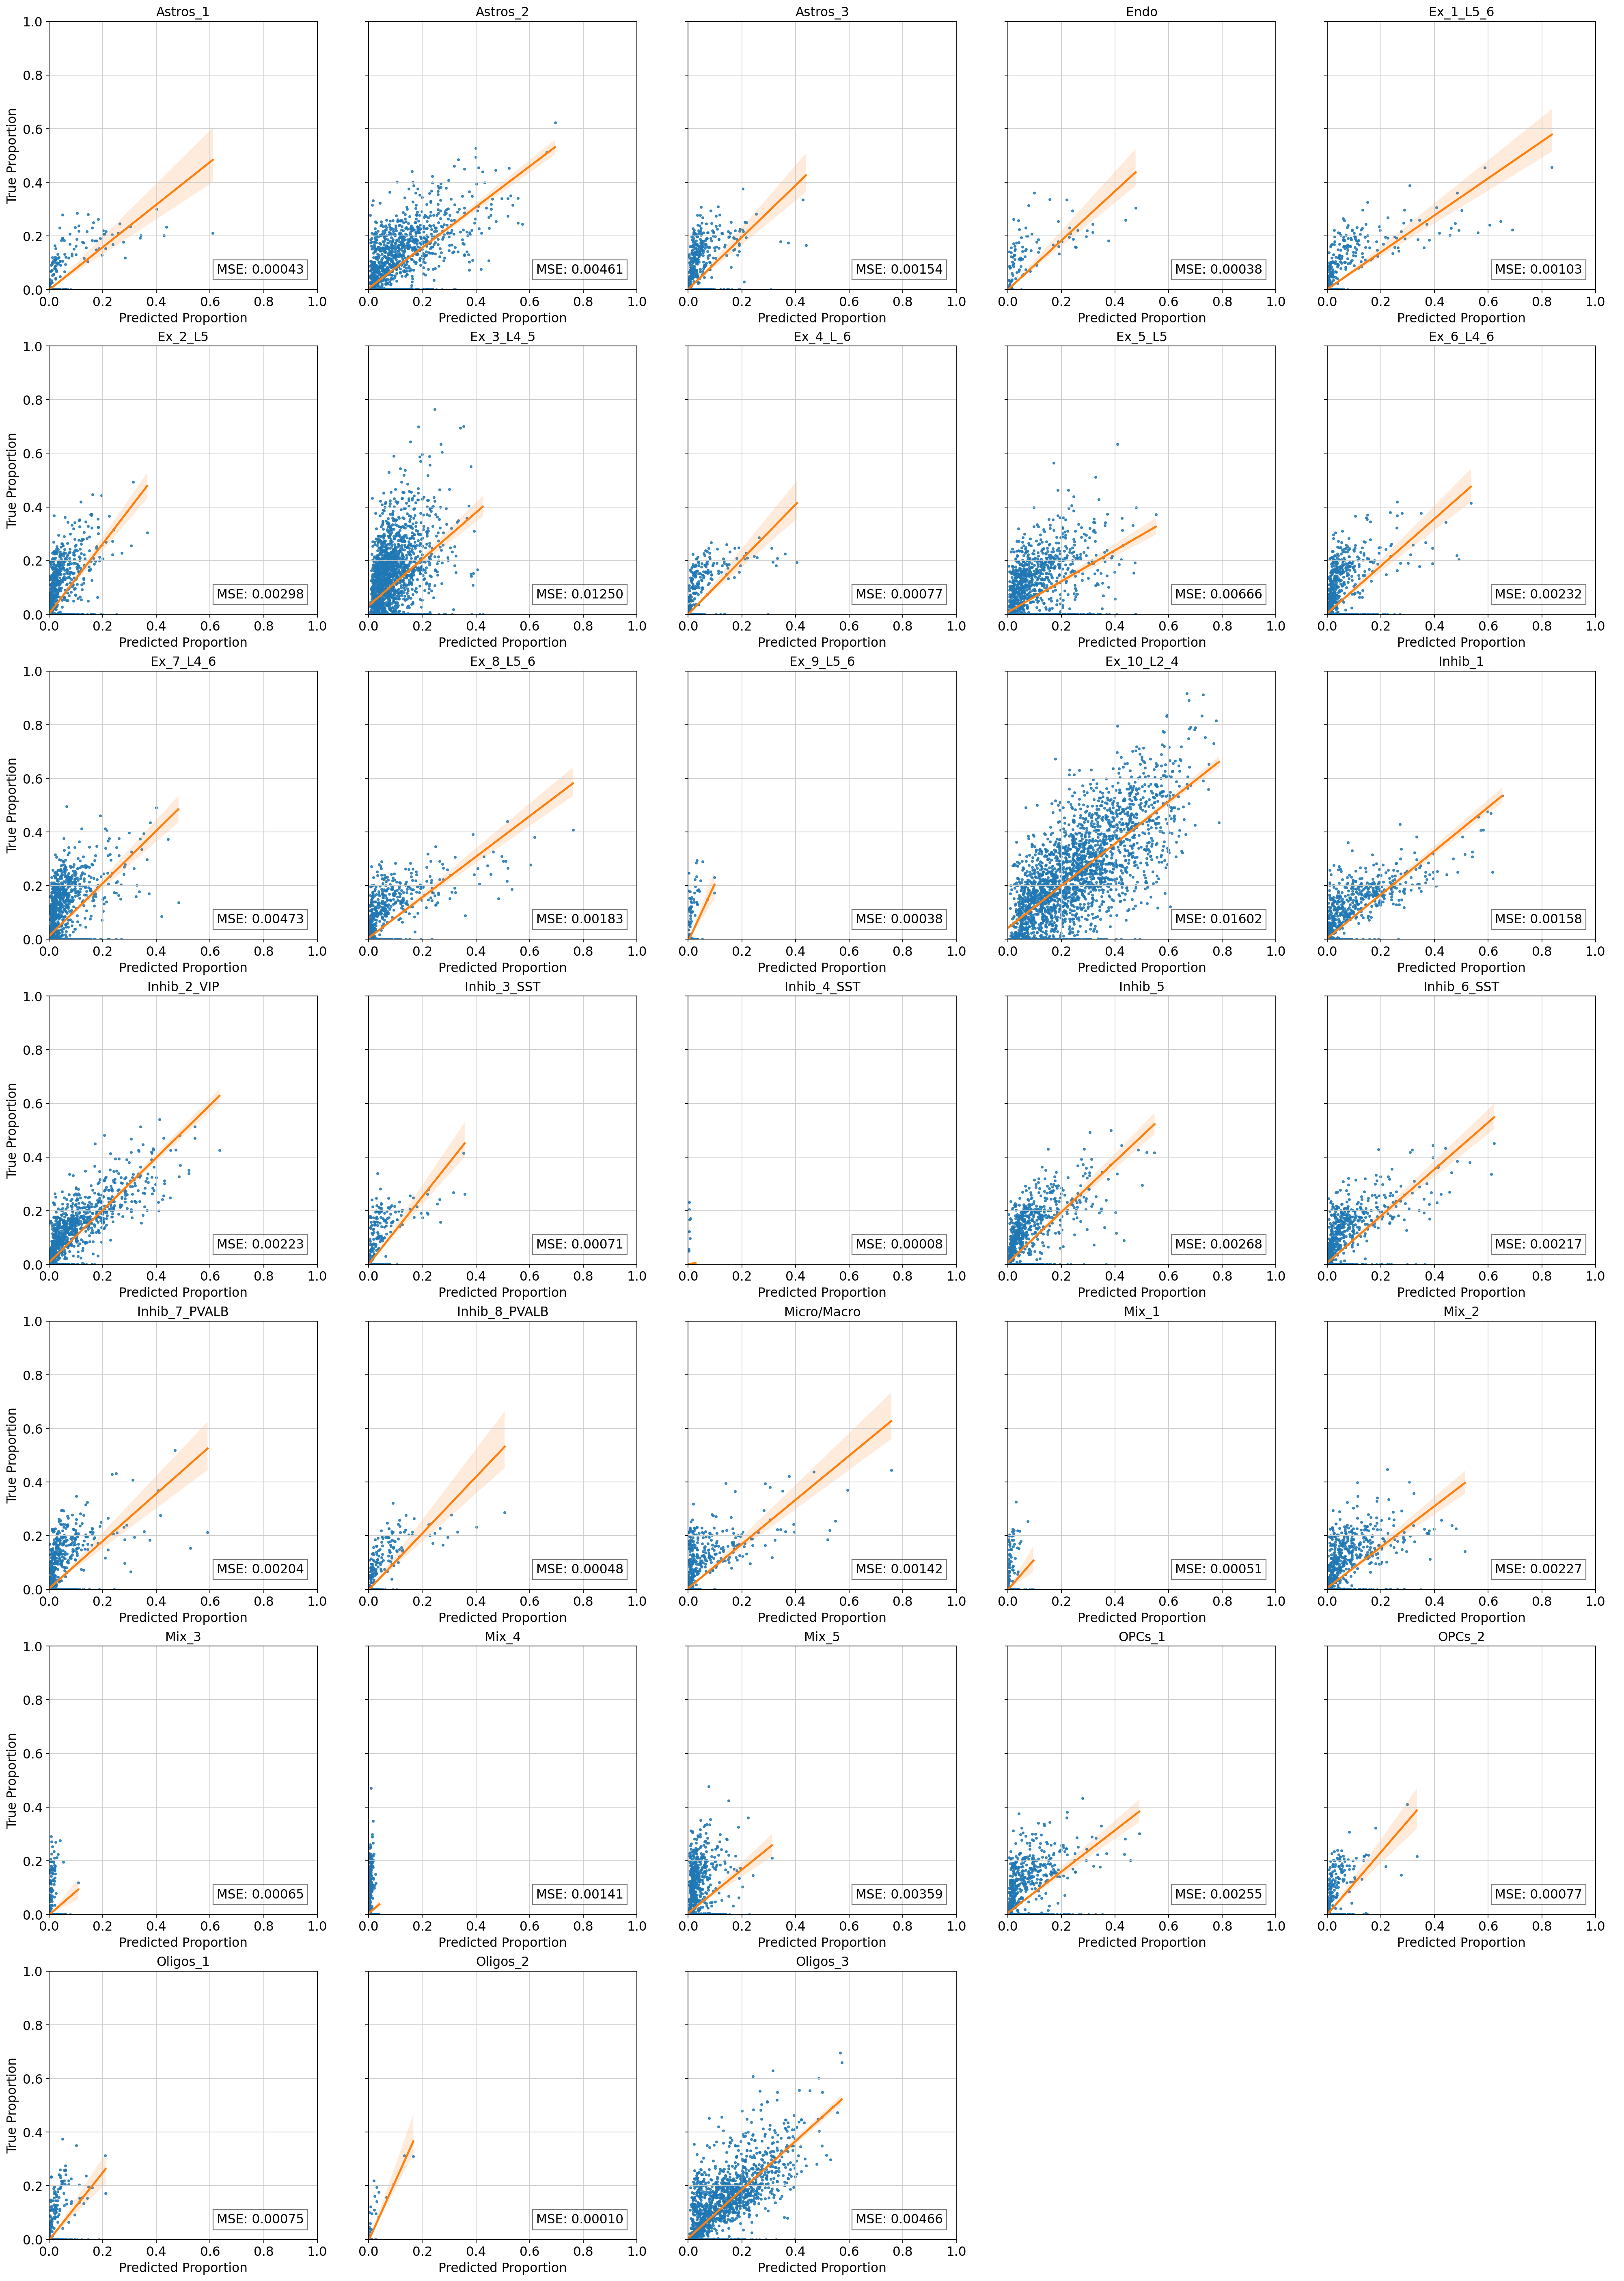

In [41]:
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"best_model.pth"))
else:
    best_checkpoint = torch.load(
        os.path.join(advtrain_folder, SAMPLE_ID_N, f"best_model.pth")
    )

model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

with torch.no_grad():
    pred_mix = (
        F.softmax(model(torch.Tensor(sc_mix_test_s).to(device)), dim=1)
        .detach()
        .cpu()
        .numpy()
    )

cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {"color": "tab:orange"}
scatter_kws = {"s": 5}

props = dict(facecolor="w", alpha=0.5)

fig, ax = plt.subplots(
    nrows,
    5,
    figsize=(25, 5 * nrows),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)
for i, visnum in enumerate(cell_type_nums):
    sns.regplot(
        x=pred_mix[:, visnum],
        y=lab_mix_test[:, visnum],
        line_kws=line_kws,
        scatter_kws=scatter_kws,
        ax=ax.flat[i],
    ).set_title(sc_sub_dict[visnum])

    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlabel("Predicted Proportion")

    if i % 5 == 0:
        ax.flat[i].set_ylabel("True Proportion")
    else:
        ax.flat[i].set_ylabel("")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    textstr = (
        f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
    )

    # place a text box in upper left in axes coords
    ax.flat[i].text(
        0.95,
        0.05,
        textstr,
        transform=ax.flat[i].transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

for i in range(len(cell_type_nums), nrows * 5):
    ax.flat[i].axis("off")

plt.show()
